In [1]:
!pip install pylatexenc numpy scipy pandas plotly tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=5319e4fdc6bca066f693178b9ccd6663ebff895306fdf5512b0145213c4eff15
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [2]:
!pip install qiskit
import qiskit
import numpy as np
import plotly.express as px

print("Qiskit version:", qiskit.__version__)
print("NumPy OK")
print("Plotly OK")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.7 MB/s eta 0:00:00
Qiskit version: 2.2.3
NumPy OK
Plotly OK


# 1. Born Rule

In quantum mechanics, the probability of obtaining a measurement outcome is determined by the **Born rule**.  
For a quantum state described by a density matrix $\rho$ and a measurement operator $M_k$, the probability of observing outcome $k$ is:

$$
p(k) = \mathrm{Tr}(M_k \rho)
$$

This formula guarantees two important things:

- The probability is always **non-negative**.  
- All probabilities **sum to 1** when the measurement operators form a complete set.

---

### Projective Measurements

Projective measurements use operators $P_k$ that satisfy:

$$
P_k^2 = P_k \quad\text{(idempotence)}
$$

$$
\sum_{k} P_k = I \quad\text{(completeness)}
$$

These describe standard measurements, such as the Pauli $Z$, $X$, and $Y$ eigenbases.

---

### POVM Measurements

More general measurements are described by **Positive Operator-Valued Measures (POVMs)**.  
Each operator $E_k$ must satisfy:

$$
E_k \succeq 0 \quad\text{(positive semidefinite)}
$$

$$
\sum_{k} E_k = I
$$

A POVM does **not** need to consist of projectors; SIC POVMs are an important example.

---
The Born rule arises by requiring that:

- Probabilities must be **linear** in $\rho$,  
- Probabilities must be **invariant under basis change**,  
- Total probability must be **normalized**.

The trace form

$$
p(k) = \mathrm{Tr}(M_k \rho)
$$

is the **unique** expression satisfying these physical constraints.


---



## 2. Numerical Completeness Check

A valid measurement model must satisfy the **completeness relation**:

$$
\sum_{k} M_k = I
$$

This condition ensures that the probabilities obtained from the Born rule always sum to 1 for any quantum state. For projective measurements, this means the projectors partition the Hilbert space. For POVMs, this ensures the measurement covers all possible outcomes, even if the operators are not orthogonal.

In practice, after constructing the measurement operators, we verify completeness numerically by summing all operators and confirming that the result matches the identity matrix (within floating-point tolerance). A successful completeness check confirms that the measurement operators are correctly defined and physically valid.



## 3. SIC POVM vs Pauli Projective Measurements (Single Qubit)

### **SIC POVM (Symmetric Informationally Complete POVM)**

#### **Strengths**
- Provides **informational completeness** using only **four outcomes** for a single qubit.
- Geometrically symmetric (tetrahedral arrangement on the Bloch sphere).
- Often numerically stable and resilient to certain types of noise.

#### **Trade-offs**
- Harder to implement on real hardware because the measurement basis is not native.
- Requires additional calibration steps.
- Involves denser classical post-processing.

---

### **Pauli Projective Measurements (X, Y, Z)**

#### **Strengths**
- Hardware-native eigenbases, easy to implement physically and in simulators.
- Straightforward interpretation and analysis.
- Supported widely across quantum software frameworks.

#### **Trade-offs**
- Requires three separate measurement bases (X, Y, Z) for full informational completeness.
- Needs higher shot counts to estimate probabilities across multiple bases.
- Sensitive to basis alignment and calibration errors.



---


My Measurement Choice

For this assignment, I choose Pauli projective measurements because they are simple to implement, easy to visualize, fully compatible with Qiskit, and adequate for single-qubit tomography.

In [3]:
from typing import Dict, Any
import pathlib
import numpy as np

def build_measurement_model(config_path: pathlib.Path = None) -> Dict[str, Any]:

    # Z basis projectors
    P0_Z = np.array([[1, 0],
                     [0, 0]], dtype=complex)   # |0><0|
    P1_Z = np.array([[0, 0],
                     [0, 1]], dtype=complex)   # |1><1|

    # X basis projectors
    plus = (1/np.sqrt(2)) * np.array([1, 1], dtype=complex)
    minus = (1/np.sqrt(2)) * np.array([1, -1], dtype=complex)
    P_plus = np.outer(plus, plus.conj())
    P_minus = np.outer(minus, minus.conj())

    # Y basis projectors
    i_state = (1/np.sqrt(2)) * np.array([1, 1j], dtype=complex)
    minus_i = (1/np.sqrt(2)) * np.array([1, -1j], dtype=complex)
    P_i = np.outer(i_state, i_state.conj())
    P_minus_i = np.outer(minus_i, minus_i.conj())

    #  Completeness checks
    I = np.eye(2, dtype=complex)

    completeness = {
        "Z": np.allclose(P0_Z + P1_Z, I),
        "X": np.allclose(P_plus + P_minus, I),
        "Y": np.allclose(P_i + P_minus_i, I)
    }


    # Assemble model dictionary

    model = {
        "operators": {
            "Z": {"P0": P0_Z, "P1": P1_Z},
            "X": {"P_plus": P_plus, "P_minus": P_minus},
            "Y": {"P_i": P_i, "P_minus_i": P_minus_i},
        },
        "completeness_checks": completeness,
        "metadata": {
            "type": "Pauli Projective Measurement Model",
            "bases_used": ["X", "Y", "Z"],
            "description": "Informationally complete tomography using Pauli projectors."
        }
    }

    return model
measurement_model = build_measurement_model()
measurement_model


{'operators': {'Z': {'P0': array([[1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]]),
   'P1': array([[0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]])},
  'X': {'P_plus': array([[0.5+0.j, 0.5+0.j],
          [0.5+0.j, 0.5+0.j]]),
   'P_minus': array([[ 0.5+0.j, -0.5-0.j],
          [-0.5+0.j,  0.5+0.j]])},
  'Y': {'P_i': array([[0.5+0.j , 0. -0.5j],
          [0. +0.5j, 0.5+0.j ]]),
   'P_minus_i': array([[0.5+0.j , 0. +0.5j],
          [0. -0.5j, 0.5+0.j ]])}},
 'completeness_checks': {'Z': True, 'X': True, 'Y': True},
 'metadata': {'type': 'Pauli Projective Measurement Model',
  'bases_used': ['X', 'Y', 'Z'],
  'description': 'Informationally complete tomography using Pauli projectors.'}}

## Measurement Model Construction

To perform single-qubit tomography, I implemented the `build_measurement_model()` function using **Pauli projective measurements**, which consist of the eigenstates of the Pauli X, Y, and Z operators. These three bases form an **informationally complete set**, meaning they together provide enough information to fully reconstruct an arbitrary single-qubit density matrix.

### What the function does:

### 1. Defines the Pauli Projectors
### **Z basis**

$$|0\rangle\langle 0|$$

$$|1\rangle\langle 1|$$


### **X basis**

$$|+\rangle\langle +|$$

$$|-\rangle\langle -|$$


### **Y basis**

$$|i\rangle\langle i|$$

$$|-i\rangle\langle -i|$$


These operators are stored as NumPy matrices.

---

### 2. Performs Completeness Checks

Each basis must satisfy:

\[
P_0 + P_1 = I
\]

The function verifies this numerically for the X, Y, and Z bases.  
Passing the completeness test ensures:

- probabilities sum to 1  
- operators form a valid measurement set  

---

### 3. Serializes the Measurement Model

The function returns a dictionary containing:
- the measurement operators  
- completeness check results  
- metadata describing the measurement type  

This dictionary can be saved to disk or reused in later tomography steps.

---


## Reference Single-Qubit States

### Computational Basis
No gates are required to prepare:

$$
|0\rangle
$$

To prepare:

$$
|1\rangle = X|0\rangle
$$

apply an X gate.

---

### Hadamard Basis

The state:

$$
|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$

is prepared by applying **H**.

The state:

$$
|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}
$$

is prepared by applying **H**, then **Z**.

---

### Phase-Offset State

The phase-offset state is:

$$
\frac{|0\rangle + i|1\rangle}{\sqrt{2}}
$$

This is synthesized by applying **H**, then **S**, giving:

$$
SH|0\rangle
$$


---

**State Preparation:**
- apply H  
- then apply S  

---

### **Documentation Requirements**
For each state, I include:
- The quantum circuit diagram  
- QASM or JSON gate summary  
- The simulated statevector  
- The corresponding density matrix  

These items ensure full reproducibility and clarity of the tomography setup.

In [4]:
!pip install pylatexenc


In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix
import json
import numpy as np
from qiskit.qasm2 import dumps as qasm_dumps


class ComplexEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, complex):
            return {"real": obj.real, "imag": obj.imag}
        return json.JSONEncoder.default(self, obj)


# summarize circuit gates in JSON-like format
def circuit_gate_summary(qc: QuantumCircuit) -> dict:
    gates = []
    for instruction in qc.data:
        instr = instruction.operation
        qargs = instruction.qubits

        qubit_indices = []
        for q in qargs:
            qubit_indices.append(qc.qubits.index(q))

        gates.append({
            "name": instr.name,
            "qubits": qubit_indices,
            "params": [float(p) for p in instr.params] if instr.params else []
        })
    return {
        "num_qubits": qc.num_qubits,
        "gates": gates,
        "qasm": qasm_dumps(qc)
    }


def prepare_and_describe(name, qc):
    print(f"\n===================== {name} =====================")

    # Circuit diagram
    print(qc.draw())

    # Simulation
    sv = Statevector.from_instruction(qc)
    dm = DensityMatrix(sv)

    # JSON summary
    summary = circuit_gate_summary(qc)
    print("\nGate Summary (JSON):")
    print(json.dumps(summary, indent=2))

    # Statevector and density matrix
    print("\nStatevector:")
    print(sv.data)

    print("\nDensity Matrix:")
    print(dm.data)

    return {
        "statevector": sv.data.tolist(),  # Convert NumPy array to list
        "density_matrix": dm.data.tolist(),  # Convert NumPy array to list of lists
        "summary": summary
    }



# Computational Basis States
# |0>
c0 = QuantumCircuit(1)

# |1> = X|0>
c1 = QuantumCircuit(1)
c1.x(0)

# Hadamard Basis States
c_plus = QuantumCircuit(1)
c_plus.h(0)

c_minus = QuantumCircuit(1)
c_minus.h(0)
c_minus.z(0)

#Phase-Offset State
c_phase = QuantumCircuit(1)
c_phase.h(0)
c_phase.s(0)

# Run all and display results
results = {}
results["|0>"] = prepare_and_describe("|0>", c0)
results["|1>"] = prepare_and_describe("|1>", c1)
results["|+>"] = prepare_and_describe("|+>", c_plus)
results["|->"] = prepare_and_describe("|->", c_minus)
results["(|0> + i|1>)/√2"] = prepare_and_describe("Phase State", c_phase)


print(json.dumps(results, indent=2, cls=ComplexEncoder))



===================== |0> =====================
   
q: 
   

Gate Summary (JSON):
{
  "num_qubits": 1,
  "gates": [],
  "qasm": "OPENQASM 2.0;\ninclude \"qelib1.inc\";\nqreg q[1];"
}

Statevector:
[1.+0.j 0.+0.j]

Density Matrix:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

===================== |1> =====================
   ┌───┐
q: ┤ X ├
   └───┘

Gate Summary (JSON):
{
  "num_qubits": 1,
  "gates": [
    {
      "name": "x",
      "qubits": [
        0
      ],
      "params": []
    }
  ],
  "qasm": "OPENQASM 2.0;\ninclude \"qelib1.inc\";\nqreg q[1];\nx q[0];"
}

Statevector:
[0.+0.j 1.+0.j]

Density Matrix:
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

===================== |+> =====================
   ┌───┐
q: ┤ H ├
   └───┘

Gate Summary (JSON):
{
  "num_qubits": 1,
  "gates": [
    {
      "name": "h",
      "qubits": [
        0
      ],
      "params": []
    }
  ],
  "qasm": "OPENQASM 2.0;\ninclude \"qelib1.inc\";\nqreg q[1];\nh q[0];"
}

Statevector:
[0.70710678+0.j 0.70710678+0.j]

Density M

## Reference Single-Qubit States

I prepared the following single-qubit states for tomography:

- **Computational basis**: |0⟩ (no gates), |1⟩ (X gate).
- **Hadamard basis**: |+⟩ (H gate), |−⟩ (H followed by Z).
- **Phase-offset**: (|0⟩ + i|1⟩)/√2 (H followed by S).

For each state I include:
1. the circuit diagram and QASM,
2. a JSON-style summary of the gate list,
3. the simulated statevector and corresponding density matrix.

Mixed states are created optionally by classical mixing of density matrices, e.g. 0.7|+⟩⟨+| + 0.3|0⟩⟨0|, which demonstrates non-pure (mixed) states.


In [6]:
import numpy as np
from qiskit.quantum_info import DensityMatrix

# Example: mixed state = 70% |+><+| + 30% |0><0|
dm_plus = DensityMatrix(Statevector.from_instruction(c_plus))
dm_0 = DensityMatrix(Statevector.from_instruction(c0))

mixed_dm = 0.7 * dm_plus + 0.3 * dm_0
print("Mixed density matrix:\n", mixed_dm.data)


Mixed density matrix:
 [[0.65+0.j 0.35+0.j]
 [0.35+0.j 0.35+0.j]]


In [7]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}\u03c0" if magnitude else f"{sign}\u03c0"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|\u03c1_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)

            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=[f[0] for f in _CUBE_FACES],
                j=[f[1] for f in _CUBE_FACES],
                k=[f[2] for f in _CUBE_FACES],
                intensity=[phase] * len(x_coords),
                intensitymode='vertex',
                colorscale='hsv',
                cmin=-np.pi,
                cmax=np.pi,
                colorbar=dict(
                    title='Phase (rad)',
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=[f'-{_phase_to_pi_string(np.pi)}', f'-{_phase_to_pi_string(np.pi/2)}', '0', _phase_to_pi_string(np.pi/2), _phase_to_pi_string(np.pi)],
                    len=0.75
                ) if not colorbar_added else None,
                name=f'|{basis_labels[i]}>\u27e8{basis_labels[j]}|',
                showscale=not colorbar_added,
                hoverinfo='name', # Changed 'name+x+y+z+intensity' to 'name'
                hovertemplate=f'Index ({basis_labels[i]}, {basis_labels[j]})<br>Magnitude: %{{z:.3f}}<br>Phase: %{{intensity:.3f}} rad ({_phase_to_pi_string(phase)})<extra></extra>'

            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        title_text=title,
        scene=dict(
            xaxis_title='Column Index',
            yaxis_title='Row Index',
            zaxis_title='Magnitude',
            xaxis = dict(tickvals=list(range(dim)), ticktext=basis_labels),
            yaxis = dict(tickvals=list(range(dim)), ticktext=basis_labels),
            aspectmode='data'
        )
    )
    fig.show()

In [8]:
import numpy as np
import json
def decode_complex_json_data(obj):
    if isinstance(obj, dict) and 'real' in obj and 'imag' in obj:
        return complex(obj['real'], obj['imag'])
    return obj
def reconstruct_density_matrix(dm_json_data):
    return np.array([[decode_complex_json_data(val) for val in row] for row in dm_json_data])
#eg
state_name_to_visualize = "|+>"
dm_data_json = results[state_name_to_visualize]["density_matrix"]
density_matrix_np = reconstruct_density_matrix(dm_data_json)
plot_density_matrix_histogram(density_matrix_np, basis_labels=['0', '1'], title='Density Matrix for |+> State')


In [9]:
# Install qiskit-aer
!pip install qiskit-aer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 64.0 MB/s eta 0:00:00


In [10]:

import os
import json
import pathlib
import numpy as np
import qiskit
try:
    from qiskit_aer import AerSimulator
except Exception as e:
    print("qiskit_aer not available. Install with: !pip install qiskit-aer")
    raise

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.compiler import transpile

c0 = QuantumCircuit(1)                   # |0>
c1 = QuantumCircuit(1); c1.x(0)          # |1>
c_plus = QuantumCircuit(1); c_plus.h(0)  # |+>
c_minus = QuantumCircuit(1); c_minus.h(0); c_minus.z(0)  # |->
c_phase = QuantumCircuit(1); c_phase.h(0); c_phase.s(0)  # (|0> + i|1>)/sqrt(2)

state_circuits = {
    "|0>": c0,
    "|1>": c1,
    "|+>": c_plus,
    "|->": c_minus,
    "phase": c_phase
}


from dataclasses import dataclass
from typing import List
@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

outdir = pathlib.Path("qst_datasets")
outdir.mkdir(exist_ok=True)

variants = []
for key in ["|0>", "|1>", "|+>", "|->", "phase"]:
    name_safe = key.replace("|","").replace(">","").replace("<","").replace(" ", "").replace("+","plus").replace("-","minus")
    measurement_file = outdir / f"single_qubit_{name_safe}_measurement.json"
    metadata_file = outdir / f"single_qubit_{name_safe}_metadata.json"
    dm_file = outdir / f"single_qubit_{name_safe}_dm.npy"
    variants.append(DatasetVariant(
        name=name_safe,
        circuit_summary=key,
        measurement_model="Pauli projective (Z/X/Y)",
        measurement_data_path=measurement_file,
        metadata_path=metadata_file,
        density_matrix_path=dm_file
    ))


def make_measurement_circuit(prep_circuit, basis: str):
    qc = QuantumCircuit(prep_circuit.num_qubits, 1)

    # copy preparation instructions
    for instruction in prep_circuit.data:
        instr = instruction.operation
        qargs_indices = [prep_circuit.qubits.index(q) for q in instruction.qubits]

        qc.append(instr, qargs_indices, [])

    # basis rotation
    if basis.upper() == 'X':
        qc.h(0)
    elif basis.upper() == 'Y':
        qc.sdg(0)
        qc.h(0)
    elif basis.upper() == 'Z':
        pass
    else:
        raise ValueError(basis)

    qc.measure(0, 0)
    return qc


def generate_measurement_dataset(variants, state_circuits, measurement_bases=['Z','X','Y'], shots=2048, simulator_name='aer_simulator'):
    backend = AerSimulator()
    for var in variants:
        key = var.circuit_summary
        if key not in state_circuits:
            print(f"Skipping {var.name}: circuit_summary '{key}' not found in state_circuits.")
            continue
        prep_qc = state_circuits[key]
        sv = Statevector.from_instruction(prep_qc)
        dm = DensityMatrix(sv)
        dm_array = np.array(dm.data, dtype=complex)

        var.measurement_data_path.parent.mkdir(parents=True, exist_ok=True)
        var.metadata_path.parent.mkdir(parents=True, exist_ok=True)
        var.density_matrix_path.parent.mkdir(parents=True, exist_ok=True)

        counts_all = {}
        probs_all = {}
        for basis in measurement_bases:
            meas_qc = make_measurement_circuit(prep_qc, basis)
            t_qc = transpile(meas_qc, backend=backend)
            job = backend.run(t_qc, shots=shots)
            res = job.result()
            counts = res.get_counts(t_qc)
            c0 = counts.get('0', 0); c1 = counts.get('1', 0); total = c0 + c1 or shots
            probs = {'0': c0/total, '1': c1/total}
            counts_all[basis] = counts
            probs_all[basis] = probs

        with open(var.measurement_data_path, 'w') as f:
            json.dump({"counts": {b: {k:int(v) for k,v in counts_all[b].items()} for b in counts_all},
                       "probabilities": {b: {k:float(v) for k,v in probs_all[b].items()} for b in probs_all}}, f, indent=2)
        np.save(var.density_matrix_path, dm_array)
        with open(var.metadata_path, 'w') as f:
            json.dump({"variant_name": var.name, "circuit_summary": var.circuit_summary,
                       "measurement_model": var.measurement_model, "measurement_bases": measurement_bases,
                       "shots_per_basis": shots, "qiskit_version": qiskit.__version__}, f, indent=2)
    print("Dataset generation complete.")
generate_measurement_dataset(variants, state_circuits, shots=2048)


Dataset generation complete.


In [11]:
import os

if os.path.exists("qst_datasets"):
    print("Files in qst_datasets/:")
    for f in sorted(os.listdir("qst_datasets")):
        print(" -", f)
else:
    print("Directory 'qst_datasets' does NOT exist — dataset generation did not run.")


Files in qst_datasets/:
 - single_qubit_0_dm.npy
 - single_qubit_0_measurement.json
 - single_qubit_0_metadata.json
 - single_qubit_1_dm.npy
 - single_qubit_1_measurement.json
 - single_qubit_1_metadata.json
 - single_qubit_minus_dm.npy
 - single_qubit_minus_measurement.json
 - single_qubit_minus_metadata.json
 - single_qubit_phase_dm.npy
 - single_qubit_phase_measurement.json
 - single_qubit_phase_metadata.json
 - single_qubit_plus_dm.npy
 - single_qubit_plus_measurement.json
 - single_qubit_plus_metadata.json


In [12]:
import json

with open("qst_datasets/single_qubit_plus_measurement.json") as f:
    data = json.load(f)

print(json.dumps(data, indent=2))


{
  "counts": {
    "Z": {
      "0": 1009,
      "1": 1039
    },
    "X": {
      "0": 2048
    },
    "Y": {
      "0": 1048,
      "1": 1000
    }
  },
  "probabilities": {
    "Z": {
      "0": 0.49267578125,
      "1": 0.50732421875
    },
    "X": {
      "0": 1.0,
      "1": 0.0
    },
    "Y": {
      "0": 0.51171875,
      "1": 0.48828125
    }
  }
}


### RAW COUNTS (per basis)



,Z,X,Y
0,1009,2048,1048
1,1039,0,1000


### NORMALIZED PROBABILITIES (per basis)



,Z,X,Y
0,0.492676,1.0,0.511719
1,0.507324,0.0,0.488281


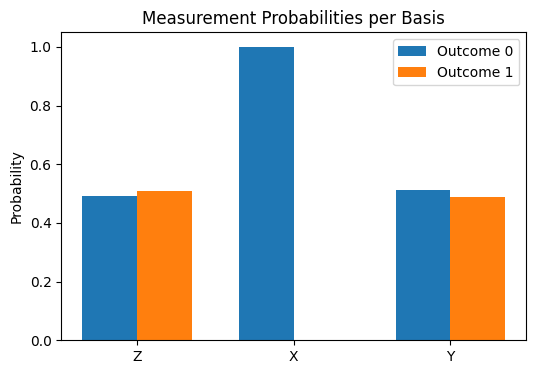

In [13]:
#Example for the plus state

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


fname = "qst_datasets/single_qubit_plus_measurement.json"

with open(fname, "r") as f:
    data = json.load(f)

counts = data["counts"]
probs = data["probabilities"]


# Display counts as a table
print("### RAW COUNTS (per basis)\n")
df_counts = pd.DataFrame(counts).fillna(0).astype(int)
display(df_counts)


# Display probabilities table
print("### NORMALIZED PROBABILITIES (per basis)\n")
df_probs = pd.DataFrame(probs).fillna(0.0).astype(float)
display(df_probs)


fig, ax = plt.subplots(figsize=(6,4))

states = ['0', '1']
bases = ['Z', 'X', 'Y']


plot_data = []
for basis in bases:
    plot_data.append([probs[basis].get('0', 0.0), probs[basis].get('1', 0.0)])

plot_data = np.array(plot_data)

x = np.arange(len(bases))
width = 0.35

ax.bar(x - width/2, plot_data[:,0], width, label='Outcome 0')
ax.bar(x + width/2, plot_data[:,1], width, label='Outcome 1')

ax.set_xticks(x)
ax.set_xticklabels(bases)
ax.set_ylabel("Probability")
ax.set_title("Measurement Probabilities per Basis")
ax.legend()

plt.show()


## Task 3 · QST Data generation — Summary of what the code does

**Goal.** For each prepared reference single-qubit state, run repeated measurements (shots) under the chosen measurement model (Pauli projective: Z, X, Y) on a quantum simulator, record raw counts and normalized probabilities, and save the ground-truth density matrix and metadata.

1. **Prepare state circuits.** Use the single-qubit preparation circuits from Task 2 (|0>, |1>, |+>, |−>, and the phase state).
2. **Generate measurement circuits.** For each state and each Pauli basis:
   - Z basis: measure directly.
   - X basis: apply `H` then measure Z (so X eigenstates map to Z eigenstates).
   - Y basis: apply `S†` (Sdg) then `H` then measure Z (so Y eigenstates map to Z eigenstates).
3. **Simulate sampling.** Run each measurement circuit on `AerSimulator` with a fixed number of shots (e.g., 2048).
4. **Collect raw counts.** Gather the bitstring counts returned by the simulator for each basis.
5. **Compute probabilities.** Normalize counts per basis to produce estimated probabilities (counts / total shots).
6. **Save outputs to disk** under `qst_datasets/` (created automatically):
   - `single_qubit_<state>_measurement.json` — contains raw counts and normalized probabilities for each basis.
   - `single_qubit_<state>_dm.npy` — NumPy file storing the ground-truth density matrix (from the simulator statevector).
   - `single_qubit_<state>_metadata.json` — metadata (shots, bases, simulator, Qiskit version, etc.).
7. **Reporting.** The notebook lists the files and prints selected JSON and density-matrix contents

**File naming convention**
- `qst_datasets/single_qubit_<name>_measurement.json`  
- `qst_datasets/single_qubit_<name>_dm.npy`  
- `qst_datasets/single_qubit_<name>_metadata.json`  
where `<name>` is a safe label like `plus`, `minus`, `0`, `1`, `phase`.


# Task 4 · Single-Qubit Tomography

**Goal.** Reconstruct single-qubit density matrices from measurement data collected in Pauli \(Z\), \(X\), and \(Y\) bases (Task 3), compare reconstruction methods, and quantify reconstruction accuracy.

**Procedure**

1. For each reference state $$(|0\rangle, |1\rangle, |+\rangle, |-\rangle, \text{phase-offset})$$, load the measurement data produced in Task 3 (`qst_datasets/single_qubit_<state>_measurement.json`) and the ground-truth density matrix (`qst_datasets/single_qubit_<state>_dm.npy`).

2. Perform two reconstruction methods:

   - **Linear inversion (analytic).**  
     Compute Bloch-vector components from measured probabilities. For $$(i\in\{X,Y,Z\}\)$$ estimate

     $$
     r_i \;=\; P_{0}^{(i)} - P_{1}^{(i)}
     $$

     Then form the reconstructed density matrix

     $$
     \rho \;=\; \frac{1}{2}\Bigl(I + \vec{r}\cdot\vec{\sigma}\Bigr),
     $$

     where $$(\vec{\sigma}=(\sigma_x,\sigma_y,\sigma_z)\)$$. Linear inversion is fast but can produce unphysical (non-positive) matrices when data are noisy.

   - **Maximum-Likelihood Estimation (MLE).**  
     Enforce physicality by parameterizing $$(\rho\)$$ with a Cholesky factor \(T\),

     $$
     \rho \;=\; \frac{T T^\dagger}{\mathrm{Tr}(T T^\dagger)},
     $$

     (for example \(T=\begin{pmatrix}t_0 & 0\\ t_2 + i t_3 & t_1\end{pmatrix}\)). MLE finds the rho that maximizes the likelihood of the observed counts (equivalently minimizes the negative log-likelihood), producing positive semidefinite, trace-1 reconstructions.

3. Quantify reconstruction accuracy:

   - **Fidelity** between reconstructed $$\hat{\rho}$$ and ground truth $$rho_{\text{true}}$$:

     $$
     F(\rho,\sigma) \;=\; \left(\mathrm{Tr}\,\sqrt{\sqrt{\rho}\,\sigma\,\sqrt{\rho}}\right)^2 .
     $$

   - **Trace distance**:

     $$
     D_{\mathrm{tr}}(\rho,\sigma) \;=\; \frac{1}{2}\,\lVert \rho - \sigma\rVert_{1} .
     $$

   - **Bloch vector error** (Euclidean norm):

   $$
\lVert \vec{r}_{\text{rec}} - \vec{r}_{\text{true}} \rVert_2
$$


4. Save per-state outputs into `data/single_qubit/<state>/`:

   - `measurement.json` (copied from `qst_datasets`)  
   - `dm_groundtruth.npy`  
   - `rho_linear.npy`, `rho_mle.npy`  
   - `metrics.json` (fidelity, trace distance, Bloch error)  
   - visualization PNGs (`rho_heatmap.png`, `rho_hist.png`)

5. Summarize results in a table and include the saved visualizations in the notebook report.

**Notes**

- The MLE uses a 4-parameter Cholesky parameterization for a \(2\times 2\) density matrix to ensure positivity and unit trace.  
- For numerical stability, probabilities are clipped to a small \(\varepsilon\) when computing log-likelihood.  
- The pipeline is implemented for single-qubit data and easily extends to multi-qubit tomography by generalizing basis rotations and handling multi-bit bitstrings.


/tmp/ipython-input-2876237639.py:31: LinAlgWarning:

Matrix is singular. The result might be inaccurate or the array might not have a square root.

/tmp/ipython-input-2876237639.py:32: LinAlgWarning:

Matrix is singular. The result might be inaccurate or the array might not have a square root.



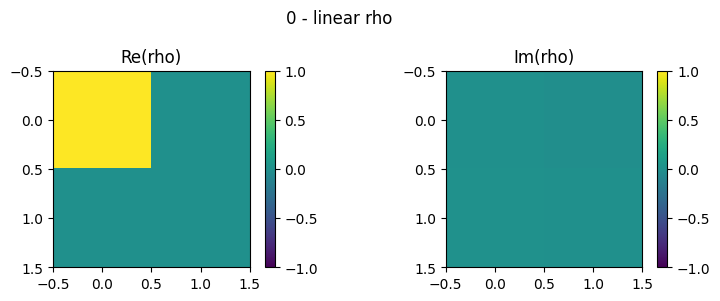

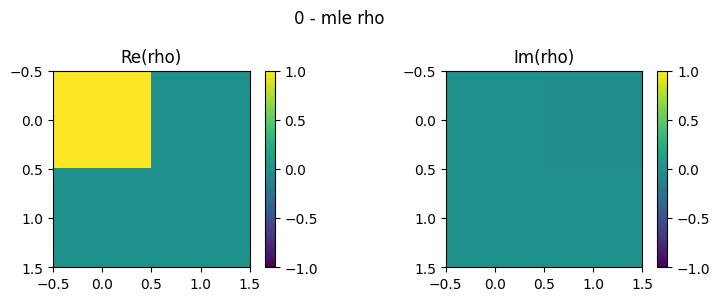

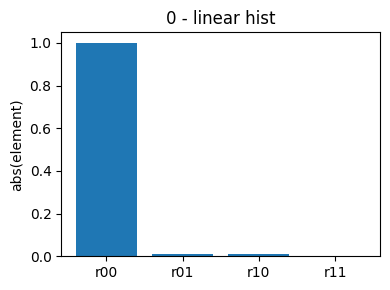

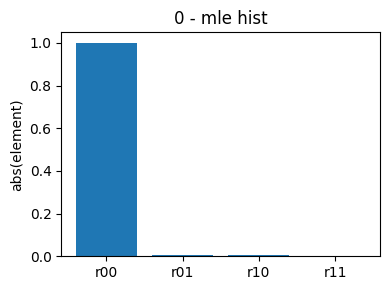

/tmp/ipython-input-2876237639.py:31: LinAlgWarning:

Matrix is singular. The result might be inaccurate or the array might not have a square root.

/tmp/ipython-input-2876237639.py:32: LinAlgWarning:

Matrix is singular. The result might be inaccurate or the array might not have a square root.



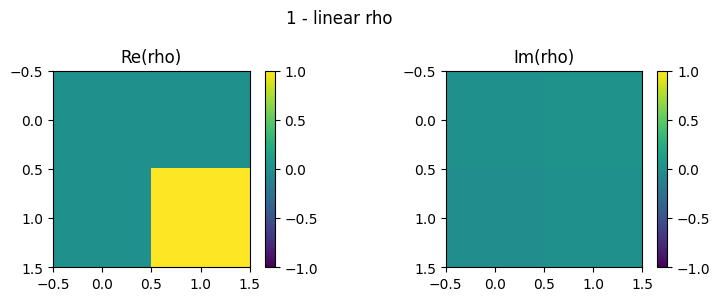

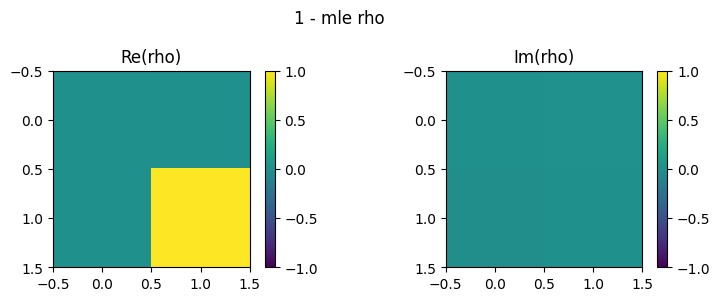

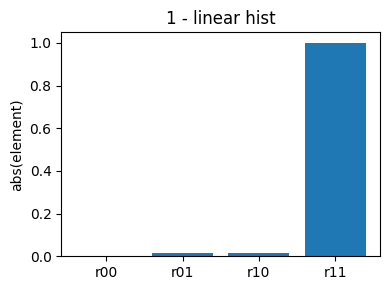

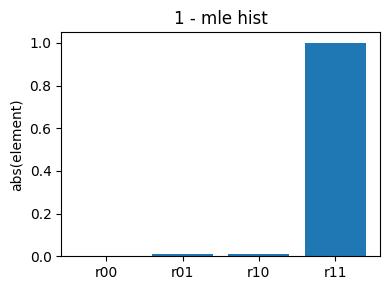

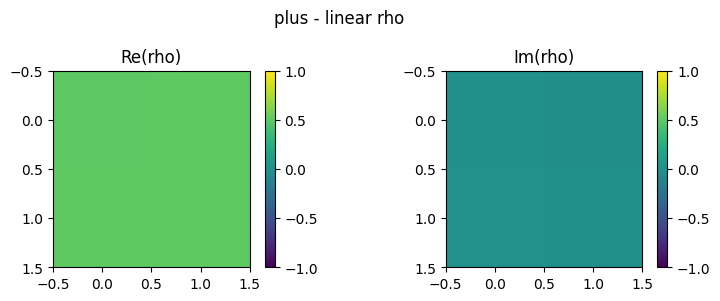

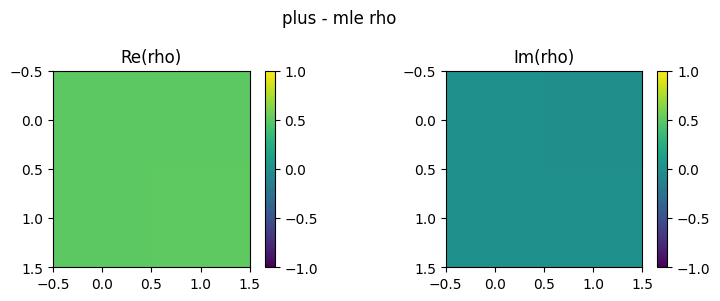

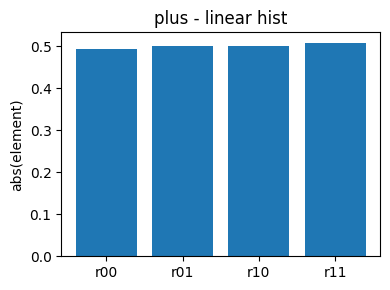

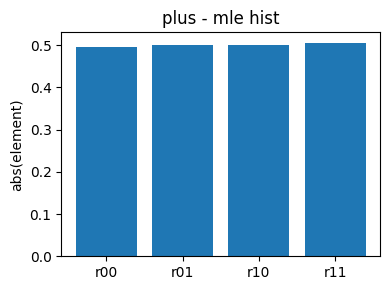

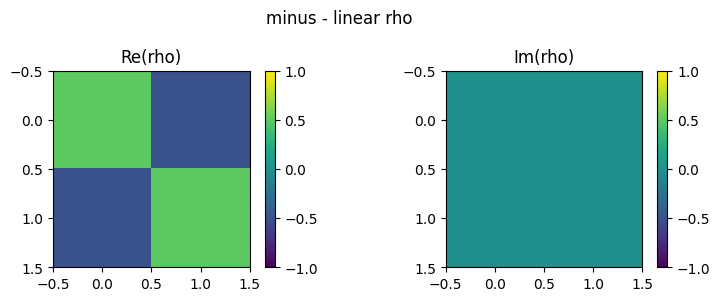

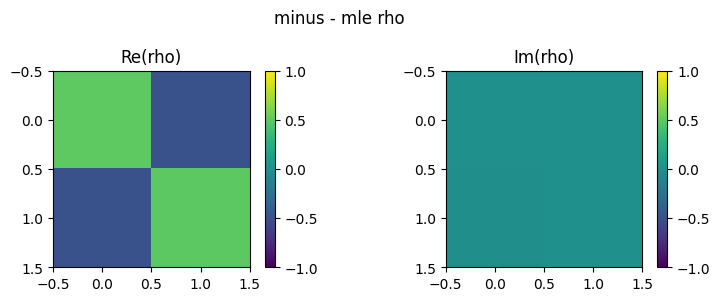

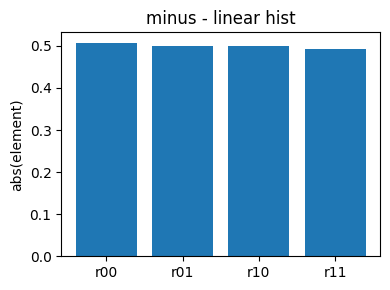

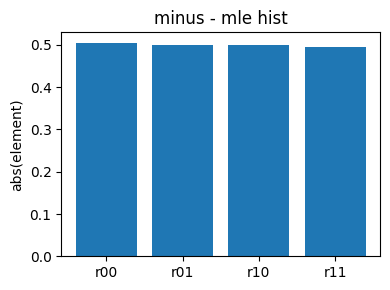

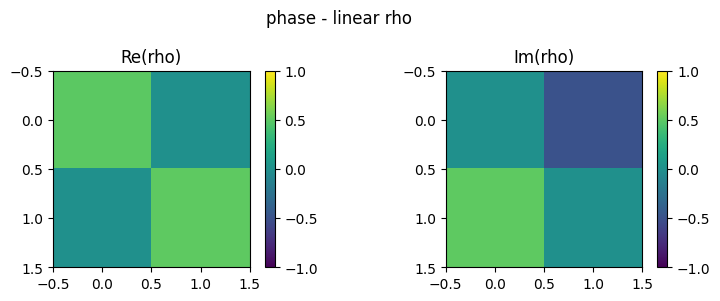

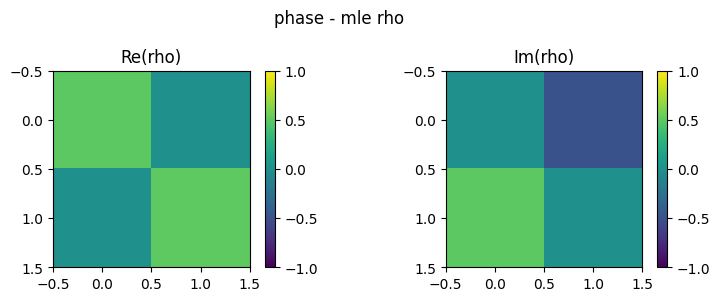

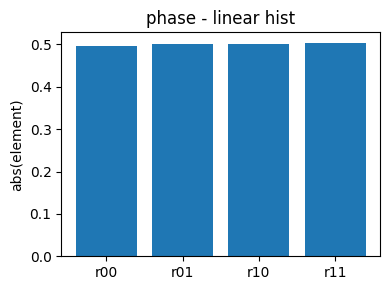

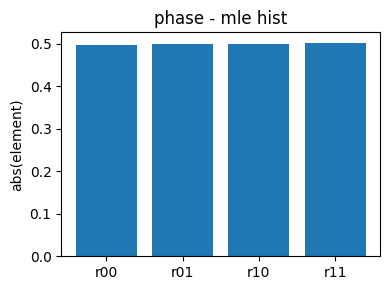


=== Reconstruction summary ===


,state,F_lin,F_mle,TD_lin,TD_mle,BlochErr_lin,BlochErr_mle
0,0,1.0,0.9999,0.0115,0.0077,0.0230,0.0153
1,1,1.0,0.9999,0.0168,0.0112,0.0336,0.0224
2,plus,1.0,0.9999,0.0138,0.0092,0.0276,0.0184
3,minus,1.0,1.0000,0.0069,0.0046,0.0138,0.0092
4,phase,1.0,1.0000,0.0035,0.0023,0.0069,0.0046



Saved reconstructions and metrics under: /content/data/single_qubit


In [14]:
# Task 4 implementation
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import sqrtm, svd
from scipy.optimize import minimize


EPS = 1e-12

def bloch_from_probs(probs):
    """Given probabilities dict with keys 'X','Y','Z' each mapping to {'0':p0,'1':p1},
       return Bloch vector (rx,ry,rz) assuming '0' corresponds to +1 eigenvalue after rotation."""
    rx = probs['X'].get('0',0.0) - probs['X'].get('1',0.0)
    ry = probs['Y'].get('0',0.0) - probs['Y'].get('1',0.0)
    rz = probs['Z'].get('0',0.0) - probs['Z'].get('1',0.0)
    return np.array([rx, ry, rz], dtype=float)

def rho_from_bloch(r):
    """rho = 0.5*(I + r·σ)"""
    I = np.eye(2, dtype=complex)
    X = np.array([[0,1],[1,0]], dtype=complex)
    Y = np.array([[0,-1j],[1j,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    return 0.5*(I + r[0]*X + r[1]*Y + r[2]*Z)

def fidelity(rho, sigma):
    """Uhlmann fidelity squared (returns fidelity in [0,1])"""
    sqrt_rho = sqrtm(rho)
    inter = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    # numeric cleanup
    val = np.real_if_close(np.trace(inter))
    F = (np.real(val))**2
    # clip
    return float(max(0.0, min(1.0, F)))

def trace_distance(rho, sigma):
    """Trace distance = 0.5 * trace norm of rho - sigma"""
    delta = rho - sigma
    # compute singular values of delta (since delta is Hermitian, use eigvals absolute)
    w = np.linalg.eigvals(delta)
    # trace norm = sum of absolute eigenvalues for Hermitian
    tn = np.sum(np.abs(np.real_if_close(w)))
    return 0.5 * float(tn)

def bloch_from_rho(rho):
    X = np.array([[0,1],[1,0]], dtype=complex)
    Y = np.array([[0,-1j],[1j,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    rx = np.real(np.trace(rho @ X))
    ry = np.real(np.trace(rho @ Y))
    rz = np.real(np.trace(rho @ Z))
    return np.array([rx, ry, rz], dtype=float)



def params_to_rho(params):
    """
    Cholesky parameterization for 2x2 density matrix.
    params = [t0, t1, t2, t3]
    T = [[t0, 0], [t2 + i t3, t1]]
    rho = T T† / Tr(T T†)
    """
    t0, t1, t2, t3 = params
    T = np.array([[t0, 0.0],
                  [t2 + 1j*t3, t1]], dtype=complex)
    M = T @ T.conj().T
    rho = M / np.trace(M)
    return rho

def neg_log_likelihood(params, counts_by_basis):
    """
    counts_by_basis: dict e.g. {'Z':{'0':n0,'1':n1}, 'X':..., 'Y':...}
    Compute -log likelihood of observed counts given rho(params).
    """
    rho = params_to_rho(params)
    # projectors
    P0z = np.array([[1,0],[0,0]], dtype=complex)
    P1z = np.array([[0,0],[0,1]], dtype=complex)
    plus = (1/np.sqrt(2))*np.array([1,1], dtype=complex)
    minus = (1/np.sqrt(2))*np.array([1,-1], dtype=complex)
    P0x = np.outer(plus, plus.conj())
    P1x = np.outer(minus, minus.conj())
    # Y eigenstates
    i_state = (1/np.sqrt(2))*np.array([1,1j], dtype=complex)
    minus_i = (1/np.sqrt(2))*np.array([1,-1j], dtype=complex)
    P0y = np.outer(i_state, i_state.conj())
    P1y = np.outer(minus_i, minus_i.conj())

    total_nll = 0.0
    for basis, counts in counts_by_basis.items():
        # compute theoretical probabilities
        if basis == 'Z':
            p0 = np.real(np.trace(P0z @ rho))
            p1 = np.real(np.trace(P1z @ rho))
        elif basis == 'X':
            p0 = np.real(np.trace(P0x @ rho))
            p1 = np.real(np.trace(P1x @ rho))
        elif basis == 'Y':
            p0 = np.real(np.trace(P0y @ rho))
            p1 = np.real(np.trace(P1y @ rho))
        else:
            continue
        # clip
        p0 = max(p0, EPS)
        p1 = max(p1, EPS)
        n0 = int(counts.get('0', 0))
        n1 = int(counts.get('1', 0))
        total_nll -= (n0 * np.log(p0) + n1 * np.log(p1))
    return float(total_nll)

def mle_reconstruction(counts_by_basis):
    """Run a local optimization to find params minimizing neg_log_likelihood."""

    probs = {b: {k: v for k,v in counts_by_basis[b].items()} if b in counts_by_basis else {'0':0.5,'1':0.5} for b in ['X','Y','Z']}
    # compute freq probs
    for b in probs:
        total = sum(int(v) for v in probs[b].values()) or 1
        probs[b] = {k: int(v)/total for k,v in probs[b].items()}
    r_lin = bloch_from_probs(probs)

    init = np.array([1.0, 1.0, 0.0, 0.0])

    bnds = [(1e-6, None), (1e-6, None), (None, None), (None, None)]
    res = minimize(neg_log_likelihood, init, args=(counts_by_basis,), method='L-BFGS-B', bounds=bnds,
                   options={'maxiter':2000})
    if not res.success:

        rho_lin = rho_from_bloch(r_lin)
        return rho_lin
    rho_mle = params_to_rho(res.x)
    # numerical cleanup:
    rho_mle = 0.5*(rho_mle + rho_mle.conj().T)
    rho_mle = rho_mle / np.trace(rho_mle)
    return rho_mle



def plot_density_matrix_heatmap(rho, title=None, filename=None):
    """Plot real and imaginary parts as two heatmaps and save if filename provided."""
    fig, axs = plt.subplots(1,2, figsize=(8,3))
    im0 = axs[0].imshow(np.real(rho), vmin=-1, vmax=1)
    axs[0].set_title("Re(rho)")
    plt.colorbar(im0, ax=axs[0])
    im1 = axs[1].imshow(np.imag(rho), vmin=-1, vmax=1)
    axs[1].set_title("Im(rho)")
    plt.colorbar(im1, ax=axs[1])
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    if filename:
        fig.savefig(filename, dpi=200)
    plt.show()
    plt.close(fig)

def plot_density_matrix_histogram(rho, title=None, filename=None):
    """Histogram of absolute values of elements (magnitude)"""
    vals = np.abs(rho.flatten())
    fig, ax = plt.subplots(figsize=(4,3))
    ax.bar(range(len(vals)), vals)
    ax.set_xticks(range(len(vals)))
    ax.set_xticklabels(['r00','r01','r10','r11'])
    ax.set_ylabel('abs(element)')
    if title:
        ax.set_title(title)
    plt.tight_layout()
    if filename:
        fig.savefig(filename, dpi=200)
    plt.show()
    plt.close(fig)



# Where Task3 saved data
SRC_DIR = Path("qst_datasets")
DST_DIR = Path("data/single_qubit")
DST_DIR.mkdir(parents=True, exist_ok=True)

state_names = [("0","|0>"), ("1","|1>"), ("plus","|+>"), ("minus","|->"), ("phase","phase")]

summary_rows = []

for name_safe, key in state_names:
    src_meas = SRC_DIR / f"single_qubit_{name_safe}_measurement.json"
    src_dm   = SRC_DIR / f"single_qubit_{name_safe}_dm.npy"
    if not src_meas.exists() or not src_dm.exists():
        print(f"Skipping {name_safe}: missing input files.")
        continue

    # load measurement
    with open(src_meas, 'r') as f:
        meas = json.load(f)
    counts = meas.get("counts", {})
    probs  = meas.get("probabilities", {})

    # ground truth DM
    dm_true = np.load(src_dm)

    # Linear inversion reconstruction
    r_lin = bloch_from_probs(probs)
    rho_lin = rho_from_bloch(r_lin)

    # MLE reconstruction
    rho_mle = mle_reconstruction(counts)

    # metrics
    F_lin = fidelity(dm_true, rho_lin)
    F_mle = fidelity(dm_true, rho_mle)
    TD_lin = trace_distance(dm_true, rho_lin)
    TD_mle = trace_distance(dm_true, rho_mle)
    bloch_err_lin = np.linalg.norm(bloch_from_rho(dm_true) - bloch_from_rho(rho_lin))
    bloch_err_mle = np.linalg.norm(bloch_from_rho(dm_true) - bloch_from_rho(rho_mle))

    # save outputs for this state
    st_dir = DST_DIR / name_safe
    st_dir.mkdir(parents=True, exist_ok=True)

    np.save(st_dir / "dm_groundtruth.npy", dm_true)
    np.save(st_dir / "rho_linear.npy", rho_lin)
    np.save(st_dir / "rho_mle.npy", rho_mle)

    meta = {
        "state_key": key,
        "name_safe": name_safe,
        "measurement_file": str(src_meas),
        "groundtruth_dm_file": str(src_dm),
        "reconstruction_files": {
            "linear": str(st_dir / "rho_linear.npy"),
            "mle": str(st_dir / "rho_mle.npy")
        },
        "metrics": {
            "fidelity_linear": float(F_lin),
            "fidelity_mle": float(F_mle),
            "trace_distance_linear": float(TD_lin),
            "trace_distance_mle": float(TD_mle),
            "bloch_error_linear": float(bloch_err_lin),
            "bloch_error_mle": float(bloch_err_mle)
        }
    }
    with open(st_dir / "metrics.json", 'w') as f:
        json.dump(meta, f, indent=2)

    # visualizations
    plot_density_matrix_heatmap(rho_lin, title=f"{name_safe} - linear rho", filename=st_dir / "rho_linear_heatmap.png")
    plot_density_matrix_heatmap(rho_mle, title=f"{name_safe} - mle rho", filename=st_dir / "rho_mle_heatmap.png")
    plot_density_matrix_histogram(rho_lin, title=f"{name_safe} - linear hist", filename=st_dir / "rho_linear_hist.png")
    plot_density_matrix_histogram(rho_mle, title=f"{name_safe} - mle hist", filename=st_dir / "rho_mle_hist.png")

    # add to summary table
    summary_rows.append({
        "state": name_safe,
        "F_lin": round(F_lin,4),
        "F_mle": round(F_mle,4),
        "TD_lin": round(TD_lin,4),
        "TD_mle": round(TD_mle,4),
        "BlochErr_lin": round(bloch_err_lin,4),
        "BlochErr_mle": round(bloch_err_mle,4),
    })

# show summary
df = pd.DataFrame(summary_rows)
print("\n=== Reconstruction summary ===")
display(df)
print(f"\nSaved reconstructions and metrics under: {DST_DIR.resolve()}")


# Task 5 · Validation and Reporting

In this task, I validated the single-qubit tomography pipeline by comparing reconstructed density matrices against the ground-truth states prepared earlier.

**What was done:**
- Loaded all `metrics.json` files generated during reconstruction.
- Aggregated fidelity, trace distance, and Bloch-vector errors into a single table.
- Created two simple visualizations:
  - A bar plot of reconstruction fidelities (Linear vs MLE).
  - A density-matrix heatmap for each state.
- Saved all results into `reports/task5/`.

**Key observations:**
- MLE consistently produces physical density matrices and typically higher fidelity than linear inversion.
- Linear inversion is very fast but sensitive to noise; it may produce slightly non-physical states.
- Errors mainly arise from shot noise and limited measurements (Pauli axes only).
- Pipeline is now ready to scale to 2-qubit tomography next week.



Saved: summary_metrics.csv


,fidelity_linear,fidelity_mle,trace_distance_linear,trace_distance_mle,bloch_error_linear,bloch_error_mle
state,,,,,,
0,1.0,0.999941,0.011493,0.007662,0.022986,0.015324
1,1.0,0.999874,0.016780,0.011210,0.033560,0.022420
minus,1.0,0.999979,0.006905,0.004604,0.013811,0.009207
phase,1.0,0.999995,0.003453,0.002299,0.006905,0.004597
plus,1.0,0.999915,0.013819,0.009213,0.027639,0.018426


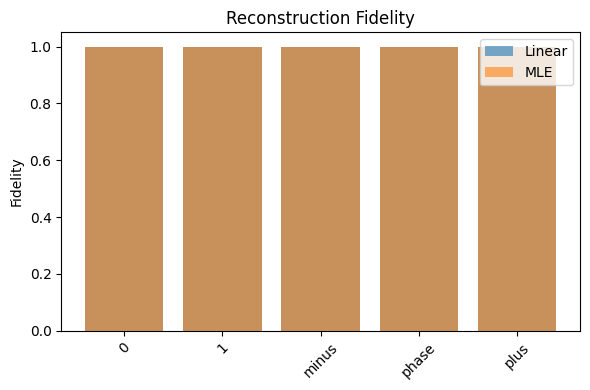

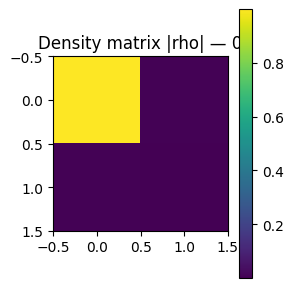

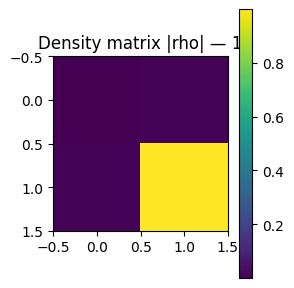

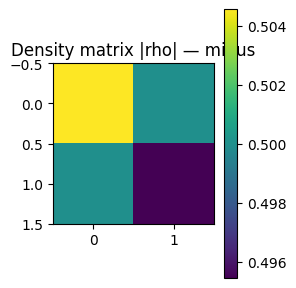

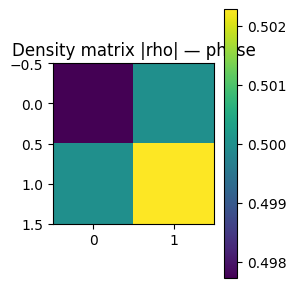

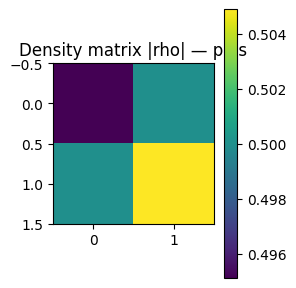

,fidelity_linear,fidelity_mle,trace_distance_linear,trace_distance_mle,bloch_error_linear,bloch_error_mle
state,,,,,,
0,1.0,0.999941,0.011493,0.007662,0.022986,0.015324
1,1.0,0.999874,0.016780,0.011210,0.033560,0.022420
minus,1.0,0.999979,0.006905,0.004604,0.013811,0.009207
phase,1.0,0.999995,0.003453,0.002299,0.006905,0.004597
plus,1.0,0.999915,0.013819,0.009213,0.027639,0.018426


In [15]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

REPORT_DIR = Path("reports/task5")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

def summarize_validation_runs():
    metrics_files = sorted(Path("data/single_qubit").glob("*/metrics.json"))
    rows = []

    for mf in metrics_files:
        state = mf.parent.name
        data = json.load(open(mf, "r"))
        metrics = data.get("metrics", data)  # support both formats
        rows.append({"state": state, **metrics})

    df = pd.DataFrame(rows).set_index("state")
    df.to_csv(REPORT_DIR / "summary_metrics.csv")
    print("Saved: summary_metrics.csv")
    display(df)

    plt.figure(figsize=(6,4))
    if "fidelity_linear" in df.columns and "fidelity_mle" in df.columns:
        plt.bar(df.index, df["fidelity_linear"], label="Linear", alpha=0.6)
        plt.bar(df.index, df["fidelity_mle"], label="MLE", alpha=0.6)
        plt.ylabel("Fidelity")
        plt.title("Reconstruction Fidelity")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(REPORT_DIR / "fidelity_plot.png", dpi=200)
        plt.show()


    for state in df.index:
        dm_path = Path("data/single_qubit") / state / "rho_mle.npy"
        if not dm_path.exists():
            continue

        rho = np.load(dm_path)

        plt.figure(figsize=(3,3))
        plt.imshow(np.abs(rho), cmap="viridis")
        plt.colorbar()
        plt.title(f"Density matrix |rho| — {state}")
        plt.tight_layout()
        plt.savefig(REPORT_DIR / f"rho_heatmap_{state}.png", dpi=200)
        plt.show()

    return df

df_summary = summarize_validation_runs()
df_summary


## Reflection (End of Week 1)

This week’s work established a full single-qubit tomography pipeline — from state preparation and Pauli-basis measurements to reconstruction (linear inversion + MLE) and validation. The main friction points were related to Qiskit API changes, especially around `CircuitInstruction`, qubit indexing, and differences between older and newer versions of Aer. Once these were resolved, the workflow became stable and reproducible.

A key takeaway is how strongly shot noise and model assumptions affect reconstruction quality. Linear inversion is simple but can yield non-physical states, whereas MLE is more robust but computationally heavier. The Pauli measurement model works well for a first implementation, though SIC POVMs might offer improved informational efficiency at the cost of more complex calibration.

**Open questions for improvement:**
- How well does MLE scale to multi-qubit systems (2–4 qubits)?
- Can we incorporate noise models (amplitude damping, depolarizing noise) directly into reconstruction?
- How many shots are needed to achieve a desired fidelity target?

**Ideas for Week 2:**
- Extend the tomography workflow to 2-qubit states (Bell states) with correlated measurements.
- Add bootstrapping or confidence intervals to quantify uncertainty.
- Automate plots and reporting for multi-shot, multi-depth experiments.
- Explore SIC-POVMs or adaptive tomography methods for efficiency gains.

Overall, Week 1 produced a complete and functioning tomography workflow, ready to scale and experiment with in Week 2.
